In [1]:
import os
from datetime import datetime
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from cbase.data_readers import cloudsat, viirs





In [2]:
def read_cloudsat(filename: Path):

    cloudsat = read_cloudsat_hdf4(filename)
    cloudsat = add_validation_ctth_cloudsat(cloudsat)
    return cloudsat



In [3]:


filename = "/home/a002602/data/cloud_base/cloudsat/2018150015649_64371_CS_2B-GEOPROF_GRANULE_P1_R05_E07_F03.hdf"
filename1 = "/home/a002602/data/cloud_base/cloudsat/2018150033525_64372_CS_2B-GEOPROF_GRANULE_P1_R05_E07_F03.hdf"
vgac_file = "/home/a002602/data/cloud_base/vgac/VGAC_VJ102MOD_A2018150_0130_n002738_K005.nc"
vgac_file1 = "/home/a002602/data/cloud_base/vgac/VGAC_VJ102MOD_A2018150_0312_n002739_K005.nc"


retv = read_cloudsat(filename)
retv1 = read_cloudsat(filename1)



In [4]:
da = xr.open_dataset(vgac_file, decode_times=False)
da1 = xr.open_dataset(vgac_file1, decode_times=False)

In [35]:
da.time.values
a = da.proj_time0.values
a.item()

3071.0626005836803

In [41]:
base_date = datetime.strptime("201001010000", "%Y%m%d%H%M") + timedelta(
        days=da.proj_time0.values.item()
    )
scn_time = [base_date + timedelta(hours=value) for value in da.time.values]
print(scn_time[-1], scn_time[0])

2018-05-30 03:12:09.538611 2018-05-30 01:30:08.690430


In [44]:
retv.all_arrays

{'clsat_max_height': None,
 'longitude': array([ -1.69267154,  -1.69473577,  -1.69679987, ..., -26.33356667,
        -26.33563042, -26.33769608]),
 'latitude': array([-0.008019  , -0.01771914, -0.0274193 , ...,  0.02818863,
         0.01848831,  0.00878799]),
 'imager_linnum': None,
 'imager_pixnum': None,
 'cloud_fraction': None,
 'validation_height': array([-9., -9., -9., ..., -9., -9., -9.]),
 'validation_height_base': array([-9., -9., -9., ..., -9., -9., -9.]),
 'elevation': array([-9999, -9999, -9999, ..., -9999, -9999, -9999]),
 'sec_1970': array([1.52764542e+09, 1.52764542e+09, 1.52764542e+09, ...,
        1.52765134e+09, 1.52765134e+09, 1.52765134e+09]),
 'CPR_Cloud_mask': array([[-9, -9, -9, ..., -9, -9, -9],
        [-9, -9, -9, ..., -9, -9, -9],
        [-9, -9, -9, ..., -9, -9, -9],
        ...,
        [-9, -9, -9, ..., -9, -9, -9],
        [-9, -9, -9, ..., -9, -9, -9],
        [-9, -9, -9, ..., -9, -9, -9]], dtype=int8),
 'MODIS_Cloud_Fraction': array([-99, -99, -99, ...

dict_keys(['clsat_max_height', 'longitude', 'latitude', 'imager_linnum', 'imager_pixnum', 'cloud_fraction', 'validation_height', 'validation_height_base', 'elevation', 'sec_1970', 'CPR_Cloud_mask', 'MODIS_Cloud_Fraction', 'MODIS_cloud_flag', 'Height', 'LO_RVOD_liquid_water_path', 'IO_RVOD_ice_water_path', 'LO_RO_liquid_water_path', 'IO_RO_ice_water_path', 'RVOD_liq_water_path', 'RVOD_ice_water_path', 'RO_liq_water_path', 'RO_ice_water_path', 'precip_liq_water_path_gm2', 'cloud_liq_water_path_gm2', 'precip_ice_water_path_gm2', 'cloud_ice_water_path_gm2', 'liq_water_path_gm2', 'ice_water_path_gm2', 'precip_liq_water_path', 'cloud_liq_water_path', 'precip_ice_water_path', 'cloud_ice_water_path', 'liq_water_path', 'ice_water_path', 'RVOD_CWC_status', 'RO_CWC_status', 'Phase', 'Profile_time', 'TAI_start', 'calipso_layer_base_altitude', 'calipso_layer_top_altitude', 'calipso_feature_classification_flags'])


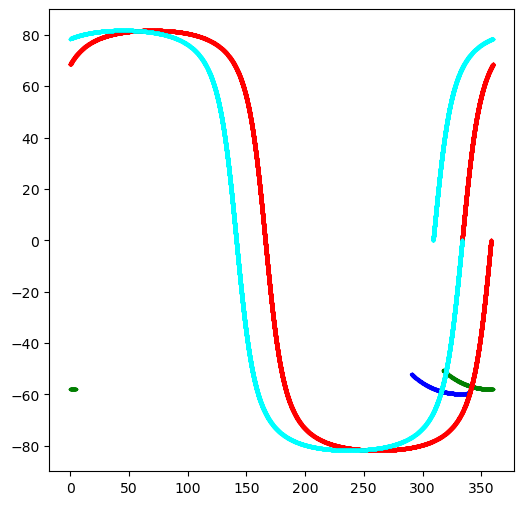

In [12]:

print(retv.all_arrays.keys())
fig, ax = plt.subplots(1, 1, figsize=[6, 6])
ax.scatter(da.lon.values[2500, :]%360, da.lat.values[2500, :], c = 'g', s=2)
ax.scatter(da1.lon.values[2500, :]%360, da1.lat.values[2500, :], c = 'b', s=2)

ax.scatter(
    retv.longitude%360,
    retv.latitude,
    c="r",s=2
)
ax.scatter(
    retv1.longitude%360,
    retv1.latitude,
    c="cyan",s=2
)
#fig.savefig("cloudsat.png")

In [7]:
da.proj_time0

<xarray.DataArray 'proj_time0' ()> Size: 8B
[1 values with dtype=float64]
Attributes:
    long_name:  Projection Origin - Time
    units:      days since 01/01/2010T00:00:00

In [8]:
da.time.values

array([0.00000000e+00, 4.96272754e-04, 4.96272754e-04, ...,
       1.69973933e+00, 1.70073188e+00, 1.70023561e+00])